<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20251803%5D%20Thesis_erformance%20Comparison%20of%20Hybrid%20RF-LSTM%20and%20SOTA%20on%20WSN-DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Training on WSN-DS dataset (5 Classes)**

In [ ]:
!pip install tensorflow

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
#Imports various Python libraries necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GRU
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

In [ ]:
# Load dataset
dataset = pd.read_csv("dataset_WSN-DS.csv")

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [ ]:
dataset

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Class
0,101000,50,1,101000,0.00000,1,0,0,25,1,0,0,0,1200,48,130.08535,0,2.46940,0
1,101001,50,0,101044,75.32345,0,4,1,0,0,1,2,38,0,0,0.00000,4,0.06957,0
2,101002,50,0,101010,46.95453,0,4,1,0,0,1,19,41,0,0,0.00000,3,0.06898,0
3,101003,50,0,101044,64.85231,0,4,1,0,0,1,16,38,0,0,0.00000,4,0.06673,0
4,101004,50,0,101010,4.83341,0,4,1,0,0,1,25,41,0,0,0.00000,3,0.06534,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374656,201096,1003,0,201051,6.98337,0,5,1,0,0,1,7,96,0,67,170.14779,3,0.15974,0
374657,201097,1003,0,201037,29.32867,0,5,1,0,0,1,31,39,0,24,82.21043,2,0.06877,0
374658,201098,1003,0,201095,18.51963,0,5,1,0,0,1,17,55,0,31,139.26438,1,0.09437,0
374659,201099,1003,0,201051,8.55001,0,5,1,0,0,1,3,96,0,65,158.27492,3,0.16047,0


In [ ]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [340066  14596  10049   6638   3312]


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler # Import StandardScaler here
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [340066 340066 340066 340066 340066]


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

In [ ]:
# Preserve original labels for non-DL models
y_train_orig, y_test_orig = y_train.copy(), y_test.copy()

# Reshape data for DL models
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Convert labels to one-hot encoding for DL models
y_train_enc = to_categorical(y_train, num_classes=5)
y_test_enc = to_categorical(y_test, num_classes=5)

# Initialize metrics storage
metrics = []

def evaluate_model(model, X_test, y_test, model_name):
    """Helper function to evaluate models and store metrics"""
    if model_name in ['Random Forest', 'SVM']: # Changed to 'Random Forest' instead of 'RF'
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)
    else:
        y_pred = np.argmax(model.predict(X_test), axis=1)
        y_proba = model.predict(X_test)

    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'AUC-ROC': roc_auc_score(y_test_enc, y_proba, multi_class='ovr'), # y_test_enc should be used here
        'FPR': confusion_matrix(y_test, y_pred)[0,1:].sum() / confusion_matrix(y_test, y_pred)[0].sum()
    }

In [ ]:
# 1. Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train_orig)
metrics.append(evaluate_model(rf_model, X_test, y_test_orig, 'Random Forest'))

In [ ]:
# prompt: Display the value of an accuracy, precision, recall, F1-Score, AUC-ROC, and FPR of the rf_model

# Assuming you have already trained and evaluated your rf_model
# and the metrics are stored in a list called 'metrics'
for metric in metrics:
  if metric['Model'] == 'Random Forest':
    print(f"Accuracy: {metric['Accuracy']}")
    print(f"Precision: {metric['Precision']}")
    print(f"Recall: {metric['Recall']}")
    print(f"F1-Score: {metric['F1-Score']}")
    print(f"AUC-ROC: {metric['AUC-ROC']}")
    print(f"FPR: {metric['FPR']}")
    break # Exit the loop once you've found the Random Forest metrics

Accuracy: 0.9991883928413896
Precision: 0.9991883529508463
Recall: 0.9991883928413896
F1-Score: 0.9991882658950102
AUC-ROC: 0.999991924335812
FPR: 0.0020437269345566287


In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    """Helper function to evaluate models and store metrics"""
    if model_name in ['Random Forest', 'SVM (Optimized)']: # Changed to 'Random Forest' instead of 'RF'
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test) # Get probability estimates for AUC-ROC
    else:
        y_pred = np.argmax(model.predict(X_test), axis=1)
        y_proba = model.predict(X_test)

    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'AUC-ROC': roc_auc_score(y_test_enc, y_proba, multi_class='ovr'), # y_test_enc should be used here
        'FPR': confusion_matrix(y_test, y_pred)[0,1:].sum() / confusion_matrix(y_test, y_pred)[0].sum()
    }

In [ ]:
# 2. Train SVM (Optimized)
from sklearn.svm import LinearSVC  # Faster than SVC for linear kernels
from sklearn.calibration import CalibratedClassifierCV  # For probability estimates

# Optimized SVM configuration
svm_model = LinearSVC(
    dual=False,  # Faster when n_samples > n_features
    tol=0.01,    # Increased tolerance for faster convergence
    C=0.1,       # Smaller regularization parameter
    max_iter=500,# Limit iterations (prevents long runs)
    random_state=42
)

# Train on subset of data (stratified sample)
_, X_train_sub, _, y_train_sub = train_test_split(
    X_train, y_train_orig,
    train_size=0.3,  # Use 30% of training data
    stratify=y_train_orig,
    random_state=42
)

# Train model
svm_model.fit(X_train_sub, y_train_sub)

# Calibrate for probability estimates
calibrated_svm = CalibratedClassifierCV(svm_model, method='sigmoid')
calibrated_svm.fit(X_train_sub, y_train_sub)

metrics.append(evaluate_model(calibrated_svm, X_test, y_test_orig, 'SVM (Optimized)'))

In [ ]:
# prompt: Display the value of an accuracy, precision, recall, F1-Score, AUC-ROC, and FPR of the SVM (Optimized)

# Assuming you have already trained and evaluated your svm_model
# and the metrics are stored in a list called 'metrics'
for metric in metrics:
  if metric['Model'] == 'SVM (Optimized)':
    print(f"Accuracy: {metric['Accuracy']}")
    print(f"Precision: {metric['Precision']}")
    print(f"Recall: {metric['Recall']}")
    print(f"F1-Score: {metric['F1-Score']}")
    print(f"AUC-ROC: {metric['AUC-ROC']}")
    print(f"FPR: {metric['FPR']}")
    break # Exit the loop once you've found the SVM (Optimized) metrics

Accuracy: 0.9011868284391853
Precision: 0.9159110835446899
Recall: 0.9011868284391853
F1-Score: 0.8985880844423346
AUC-ROC: 0.9844266683787021
FPR: 0.026818402364253893


In [ ]:
# 3. Train Standalone LSTM
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    Dense(5, activation='softmax')])

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_reshaped, y_train_enc, epochs=30, batch_size=64, validation_split=0.2, verbose=0)
metrics.append(evaluate_model(lstm_model, X_test_reshaped, y_test_orig, 'LSTM'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10628/10628 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


In [ ]:
# prompt: Display the value of an accuracy, precision, recall, F1-Score, AUC-ROC, and FPR of the LSTM

# Assuming you have already trained and evaluated your lstm_model
# and the metrics are stored in a list called 'metrics'
for metric in metrics:
  if metric['Model'] == 'LSTM':
    print(f"Accuracy: {metric['Accuracy']}")
    print(f"Precision: {metric['Precision']}")
    print(f"Recall: {metric['Recall']}")
    print(f"F1-Score: {metric['F1-Score']}")
    print(f"AUC-ROC: {metric['AUC-ROC']}")
    print(f"FPR: {metric['FPR']}")
    break # Exit the loop once you've found the LSTM metrics

Accuracy: 0.9855675074838414
Precision: 0.9860247914198959
Recall: 0.9855675074838414
F1-Score: 0.9855603591556469
AUC-ROC: 0.9995118525483759
FPR: 0.005366621087145105


In [ ]:
# 4. Train CNN
cnn_model = Sequential([
    Conv1D(64, kernel_size=1, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')])

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_train_reshaped, y_train_enc, epochs=30, batch_size=64, validation_split=0.2, verbose=0)
metrics.append(evaluate_model(cnn_model, X_test_reshaped, y_test_orig, 'CNN'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10628/10628 ━━━━━━━━━━━━━━━━━━━━ 9s 878us/step
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 10s 909us/step


In [ ]:
# prompt: Display the value of an accuracy, precision, recall, F1-Score, AUC-ROC, and FPR of the CNN

# Assuming you have already trained and evaluated your cnn_model
# and the metrics are stored in a list called 'metrics'
for metric in metrics:
  if metric['Model'] == 'CNN':
    print(f"Accuracy: {metric['Accuracy']}")
    print(f"Precision: {metric['Precision']}")
    print(f"Recall: {metric['Recall']}")
    print(f"F1-Score: {metric['F1-Score']}")
    print(f"AUC-ROC: {metric['AUC-ROC']}")
    print(f"FPR: {metric['FPR']}")
    break # Exit the loop once you've found the CNN metrics

Accuracy: 0.9829268436127104
Precision: 0.9832706959358674
Recall: 0.9829268436127104
F1-Score: 0.9829252360364366
AUC-ROC: 0.9997799989436522
FPR: 0.011791863320247599


In [ ]:
# 5. Train GRU
gru_model = Sequential([
    GRU(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    Dense(5, activation='softmax')])
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.fit(X_train_reshaped, y_train_enc, epochs=30, batch_size=64, validation_split=0.2, verbose=0)
metrics.append(evaluate_model(gru_model, X_test_reshaped, y_test_orig, 'GRU'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10628/10628 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


In [ ]:
# prompt: Display the value of an accuracy, precision, recall, F1-Score, AUC-ROC, and FPR of the GRU

# Assuming you have already trained and evaluated your gru_model
# and the metrics are stored in a list called 'metrics'
for metric in metrics:
  if metric['Model'] == 'GRU':
    print(f"Accuracy: {metric['Accuracy']}")
    print(f"Precision: {metric['Precision']}")
    print(f"Recall: {metric['Recall']}")
    print(f"F1-Score: {metric['F1-Score']}")
    print(f"AUC-ROC: {metric['AUC-ROC']}")
    print(f"FPR: {metric['FPR']}")
    break # Exit the loop once you've found the GRU metrics

Accuracy: 0.9835355489816683
Precision: 0.9840603690699632
Recall: 0.9835355489816683
F1-Score: 0.9835286712026277
AUC-ROC: 0.9993550767274486
FPR: 0.005116668872127387


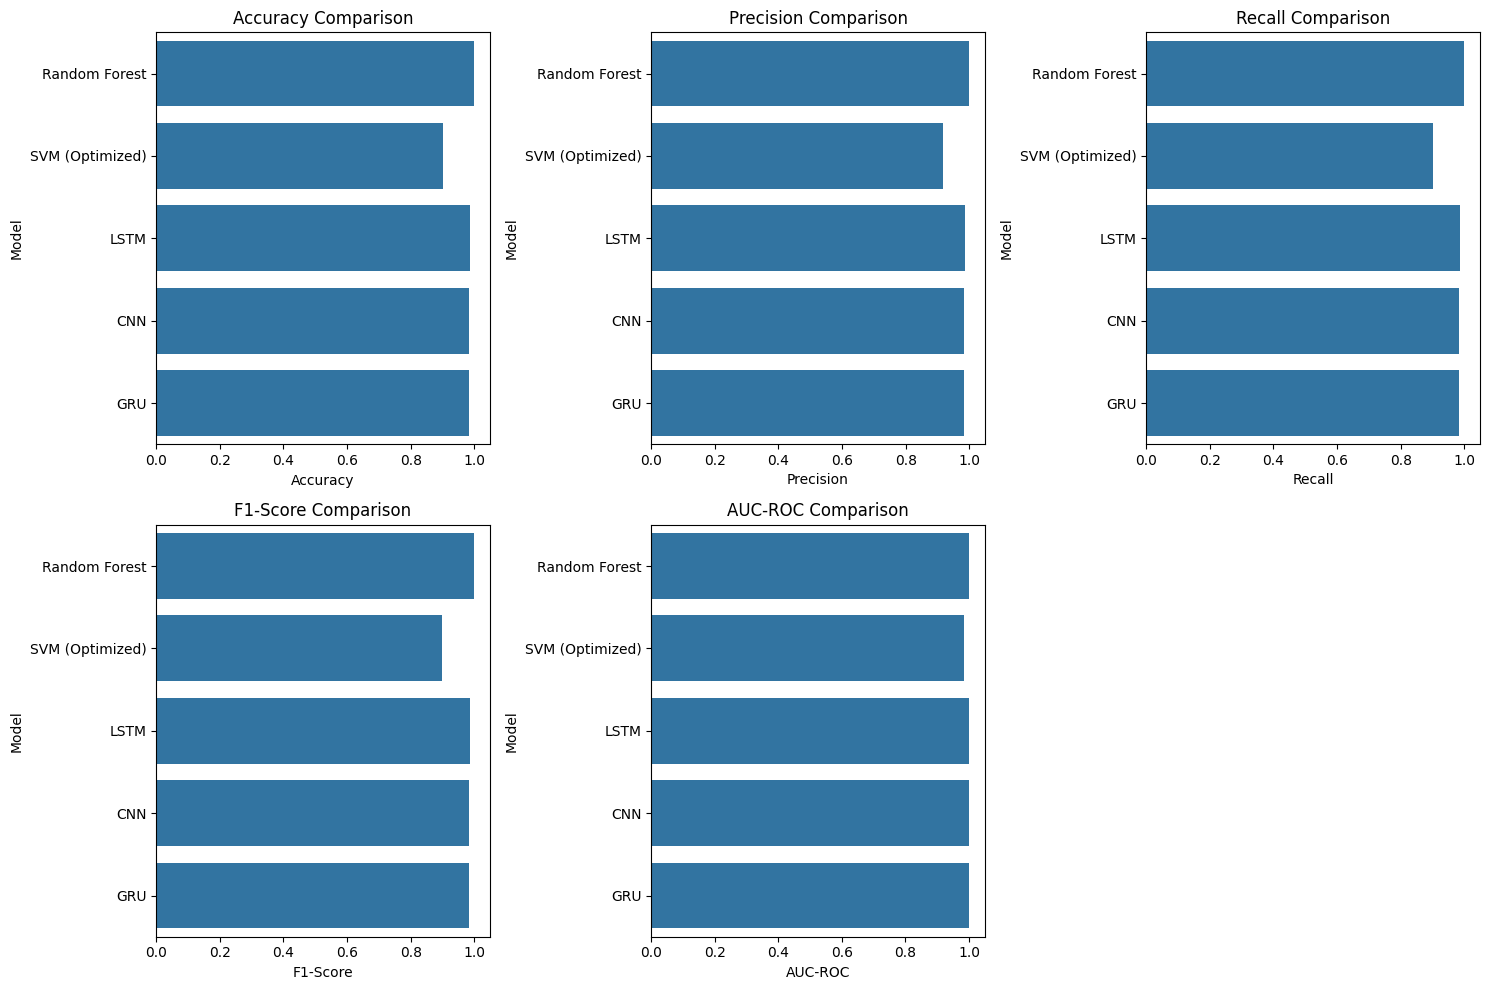


Performance Comparison:
                 Accuracy  Precision   Recall  F1-Score  AUC-ROC      FPR
Model                                                                    
Random Forest     0.99919    0.99919  0.99919   0.99919  0.99999  0.00204
SVM (Optimized)   0.90119    0.91591  0.90119   0.89859  0.98443  0.02682
LSTM              0.98557    0.98602  0.98557   0.98556  0.99951  0.00537
CNN               0.98293    0.98327  0.98293   0.98293  0.99978  0.01179
GRU               0.98354    0.98406  0.98354   0.98353  0.99936  0.00512


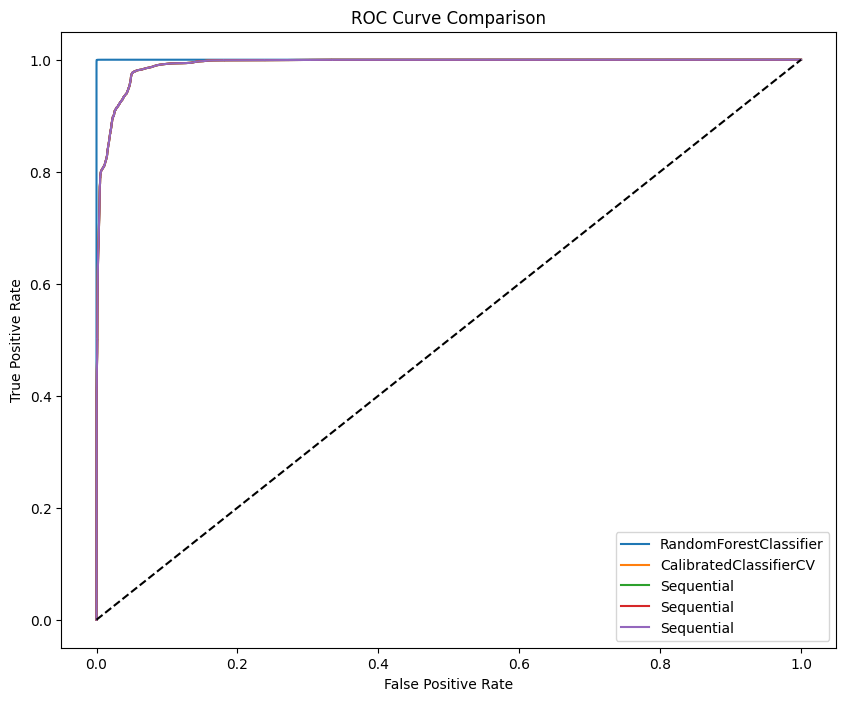

In [ ]:
# Create comparison DataFrame
results_df = pd.DataFrame(metrics).set_index('Model')

# Visualization
plt.figure(figsize=(15, 10))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=results_df[metric], y=results_df.index)
    plt.title(f'{metric} Comparison')
    plt.xlabel(metric)
plt.tight_layout()
plt.show()

# Print metrics table
print("\nPerformance Comparison:")
print(results_df.round(5))

# Import roc_curve
from sklearn.metrics import roc_curve # Import roc_curve here

# ROC Curve Comparison
plt.figure(figsize=(10, 8))
for model in [rf_model, calibrated_svm, lstm_model, cnn_model, gru_model]: # Use calibrated_svm instead of svm_model
    if hasattr(model, 'predict_proba'):
        if isinstance(model, (Sequential)): # Check if the model is a Keras model
            y_proba = model.predict(X_test_reshaped)  # Use X_test_reshaped for DL models
        else:
            y_proba = model.predict_proba(X_test)  # Use X_test for models with predict_proba
    # The elif condition is no longer needed as calibrated_svm has predict_proba
    #else:
        #y_proba = model.predict(X_test_reshaped)  # Use X_test_reshaped for DL models


    fpr, tpr, _ = roc_curve(y_test_enc.ravel(), y_proba.ravel())
    plt.plot(fpr, tpr, label=type(model).__name__)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()